In [402]:
import pandas as pd
import numpy as np

df = pd.read_excel('CNH_Macroeconomic_Data.xlsx', sheet_name ='Sheet2', skiprows=3)
df= df.rename({'Unnamed: 0': 'Date'}, axis = 1)
df = df.iloc[2:]
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df= df.astype(float)

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [403]:
# df['H1DBTO Index'].plot()

In [404]:
import pandas as pd
price = pd.read_excel('CNH_Macroeconomic_Data.xlsx', sheet_name ='Sheet1', skiprows=3)
price= price.rename({'Unnamed: 0': 'Date'}, axis = 1)
price = price.iloc[2:]
price = price.set_index('Date')
price.index = pd.to_datetime(df.index)
df['USD/CNH']= price['CNH Curncy']

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


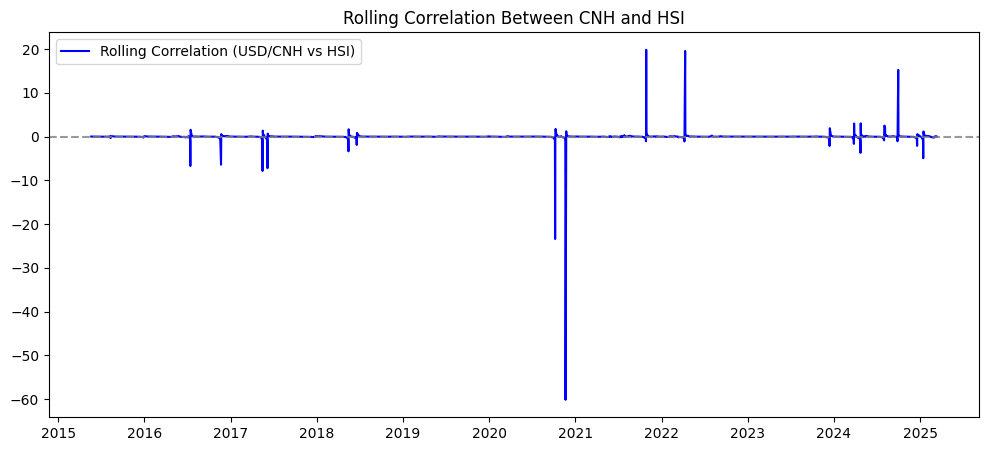

In [440]:

# Compute rolling correlation between USD/CNH and HSI
df['CNH-HSI Correlation'] = df['USD/CNH'].rolling(window=100).corr(df['HSI Index']).pct_change()

# Plot Correlation Over Time
plt.figure(figsize=(12,5))
plt.plot(df.index, df['CNH-HSI Correlation'], label="Rolling Correlation (USD/CNH vs HSI)", color="blue")
plt.axhline(0, linestyle="dashed", color="gray", alpha=0.8)
plt.title("Rolling Correlation Between CNH and HSI")
plt.legend()
plt.show()


In [441]:
df['CNH-HSI Correlation'].max()

19.850821535166485

In [442]:

# Compute EQ Spread Indicator
df['EQ Spread'] = np.log(df['HSI Index']) - np.log(df['SPX Index'])

# Compute Moving Average & Standard Deviation of EQ Spread
df['EQ Spread MA'] = df['EQ Spread'].rolling(window=30).mean()
df['EQ Spread STD'] = df['EQ Spread'].rolling(window=30).std()

# Define Upper & Lower Bands
df['Upper Band'] = df['EQ Spread MA'] + 0.5* df['EQ Spread STD']
df['Lower Band'] = df['EQ Spread MA'] - 0.5* df['EQ Spread STD']

# Define Upper & Lower Bands
df['Upper Band 2'] = df['EQ Spread MA'] + 1.5*df['EQ Spread STD']
df['Lower Band 2'] = df['EQ Spread MA'] - 1.5*df['EQ Spread STD']


In [443]:
df['EQ Spread MA'].min()

1.145968010575832

In [444]:
df['EQ Spread MA'].max()

2.57902464100286

In [445]:

# Generate Buy/Sell Signals
df['OG Signal'] = np.where(df['EQ Spread'] > df['Upper Band'], -1,  # Buy CNH (USD/CNH Long)
                        np.where(df['EQ Spread'] < df['Lower Band'], 1,  # Sell CNH (USD/CNH Short)
                                 0))  # No trade



# Reverse signal if correlation between CNH and HSI is negative
df['Final Signal'] = np.where(abs(df['CNH-HSI Correlation']) >30, -df['OG Signal'], df['OG Signal'])



<ipython-input-446-62d847b621e2>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CNH Return'] = df['USD/CNH'].pct_change()


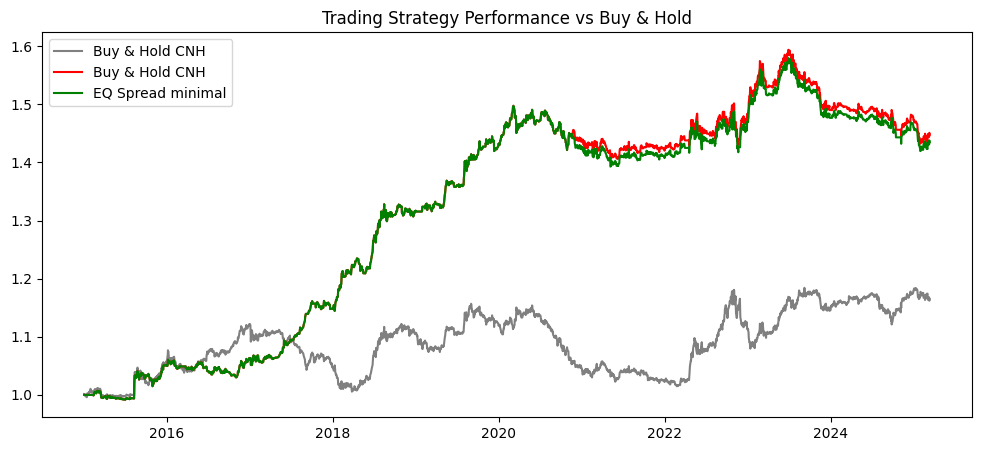

In [446]:
# Simulated P&L based on USD/CNH price movements
df['CNH Return'] = df['USD/CNH'].pct_change()
 # Use previous day's signal
df['OG Return'] = df['OG Signal'].shift(1) * df['CNH Return']  # Use previous day's signal
df['corr Return'] = df['Final Signal'].shift(1) * df['CNH Return']  # Use previous day's signal

# Compute Cumulative Returns
df['Cumulative Market Return'] = (1 + df['CNH Return']).cumprod()
df['Cumulative Strategy corr Return'] = (1 + df['corr Return']).cumprod()
df['Cumulative Strategy OG Return'] = (1 + df['OG Return']).cumprod()
# Plot Performance
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Cumulative Market Return'], label="Buy & Hold CNH", color="gray")
plt.plot(df.index, df['Cumulative Strategy corr Return'], label="Buy & Hold CNH", color="red")
plt.plot(df.index, df['Cumulative Strategy OG Return'], label="EQ Spread minimal", color="green")
# plt.plot(df.index, df['CNH-HSI Correlation'], label="Rolling Correlation (USD/CNH vs HSI)", color="yellow")
plt.title("Trading Strategy Performance vs Buy & Hold")
plt.legend()
plt.show()


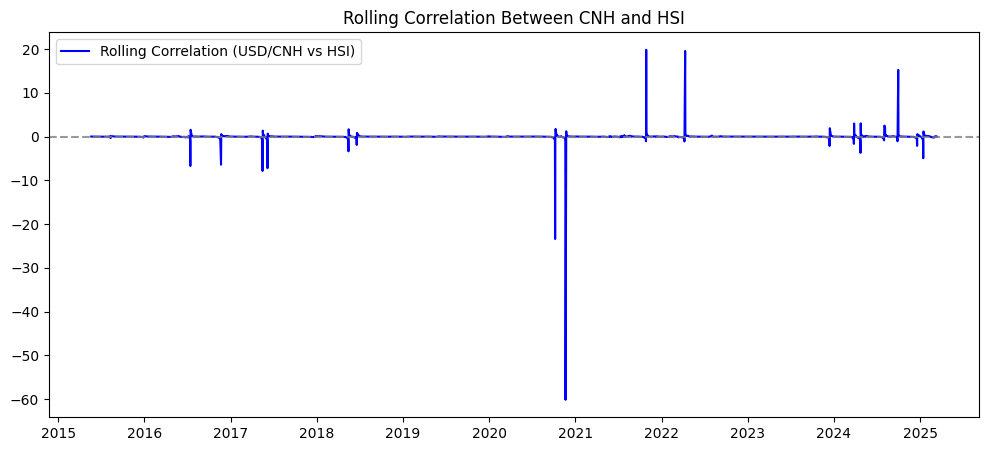

In [422]:

# Compute rolling correlation between USD/CNH and HSI
df['CNH-HSI Correlation'] = df['USD/CNH'].rolling(window=100).corr(df['HSI Index']).pct_change()

# Plot Correlation Over Time
plt.figure(figsize=(12,5))
plt.plot(df.index, df['CNH-HSI Correlation'], label="Rolling Correlation (USD/CNH vs HSI)", color="blue")
plt.axhline(0, linestyle="dashed", color="gray", alpha=0.8)
plt.title("Rolling Correlation Between CNH and HSI")
plt.legend()
plt.show()

### Carry


In [206]:
usd_rates = df['USGG2YR Index']
cnh_fx = df['USD/CNH']

In [209]:
import pandas as pd
import numpy as np
import yfinance as yf

# Calculate implied CNH yield using FX forward proxy (change in CNH spot)
cnh_implied_yield = cnh_fx.pct_change().rolling(window=20).mean() * 252  # annualized proxy

# Calculate carry (USD yield - CNH implied yield)
carry = usd_rates / 100 - cnh_implied_yield

# Normalize carry to generate z-scores
carry_z = (carry - carry.mean()) / carry.std()

# Generate carry trade signals
carry_signal = pd.Series(np.where(carry_z > 0.5, -1,
                         np.where(carry_z < -0.5, 1, 0)),
                         index=carry_z.index)

# Calculate daily returns based on signals
daily_returns = cnh_fx.pct_change().shift(-1) * carry_signal

# Backtest performance metrics
cumulative_returns = (1 + daily_returns.fillna(0)).cumprod()
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

# Compile results
carry_df = pd.DataFrame({
    'USD_Yield': usd_rates,
    'CNH_Implied_Yield': cnh_implied_yield,
    'Carry': carry,
    'Carry_Z': carry_z,
    'Trade_Signal': carry_signal,
    'Daily_Returns': daily_returns,
    'Cumulative_Returns': cumulative_returns
}).dropna()

print(carry_df.tail(20))
print(f"\nSharpe Ratio: {sharpe_ratio:.2f}")



            USD_Yield  CNH_Implied_Yield     Carry   Carry_Z  Trade_Signal  \
Date                                                                         
2025-02-12     4.3548          -0.064464  0.108012  0.608935            -1   
2025-02-13     4.3067          -0.131182  0.174249  0.999114            -1   
2025-02-14     4.2589          -0.142893  0.185482  1.065280            -1   
2025-02-17     4.2589           0.006763  0.035826  0.183717             0   
2025-02-18     4.3056           0.015603  0.027453  0.134396             0   
2025-02-19     4.2676           0.005703  0.036973  0.190470             0   
2025-02-20     4.2699          -0.089957  0.132656  0.754105            -1   
2025-02-21     4.1980           0.019560  0.022420  0.104745             0   
2025-02-24     4.1747           0.002694  0.039053  0.202727             0   
2025-02-25     4.0942          -0.034314  0.075256  0.415980             0   
2025-02-26     4.0716          -0.000318  0.041034  0.214392    

<ipython-input-209-3b256c73c9b9>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cnh_implied_yield = cnh_fx.pct_change().rolling(window=20).mean() * 252  # annualized proxy
<ipython-input-209-3b256c73c9b9>:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  daily_returns = cnh_fx.pct_change().shift(-1) * carry_signal


<Axes: xlabel='Date'>

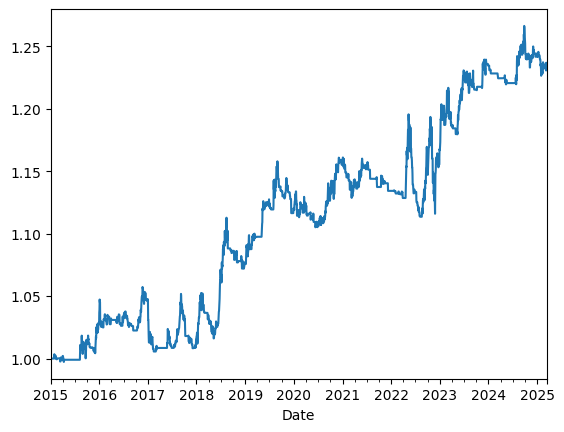

In [210]:
cumulative_returns.plot()

### Macroeconomic variables

In [286]:
df = pd.read_excel('Project BBG Data.xlsx', sheet_name ='China', skiprows=3)
df= df.rename({'Unnamed: 0': 'Date'}, axis = 1)
df = df.iloc[2:]
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df= df.astype(float)


/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [287]:
price = pd.read_excel('Project BBG Data.xlsx', sheet_name ='Currency', skiprows=3)
price= price.rename({'Unnamed: 0': 'Date'}, axis = 1)
price = price.iloc[2:]
price = price.set_index('Date')
price.index = pd.to_datetime(price.index)
price= price.astype(float)

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [297]:
df.columns

Index(['CPMINDX Index', 'CNTBI2 Index', 'CNTSTCN Index', 'CHBGRMBI Index',
       'CNUERATE Index', 'GCNY10YR Index', 'CNGDPYOY Index', 'EHCACN Index',
       'HSI Index', 'H1DBTO Index', 'SPX Index', 'USGG10YR Index',
       'USGG2YR Index', 'ECOYBCNN Index', 'CHBNINDX Index ', 'CNMSM1 Index',
       'CNMSM2 Index'],
      dtype='object')

In [298]:
df['2Y_IR']= df['CNTBI2 Index']- df['USGG2YR Index']

In [301]:
indicators = ['CPMINDX Index',
        'CNTSTCN Index',
       'CNUERATE Index',
       'EHCACN Index', 'ECOYBCNN Index', 'CHBNINDX Index ', 'CNMSM1 Index',
       'CNMSM2 Index',  '2Y_IR']
macro = df[indicators]


In [302]:
monthly_macro = macro.resample('M').last()
monthly_macro['USD/CNH'] = price[['USDCNH Curncy']].resample('M').last().values

<ipython-input-302-485841004f09>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_macro = macro.resample('M').last()
<ipython-input-302-485841004f09>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_macro['USD/CNH'] = price[['USDCNH Curncy']].resample('M').last().values


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

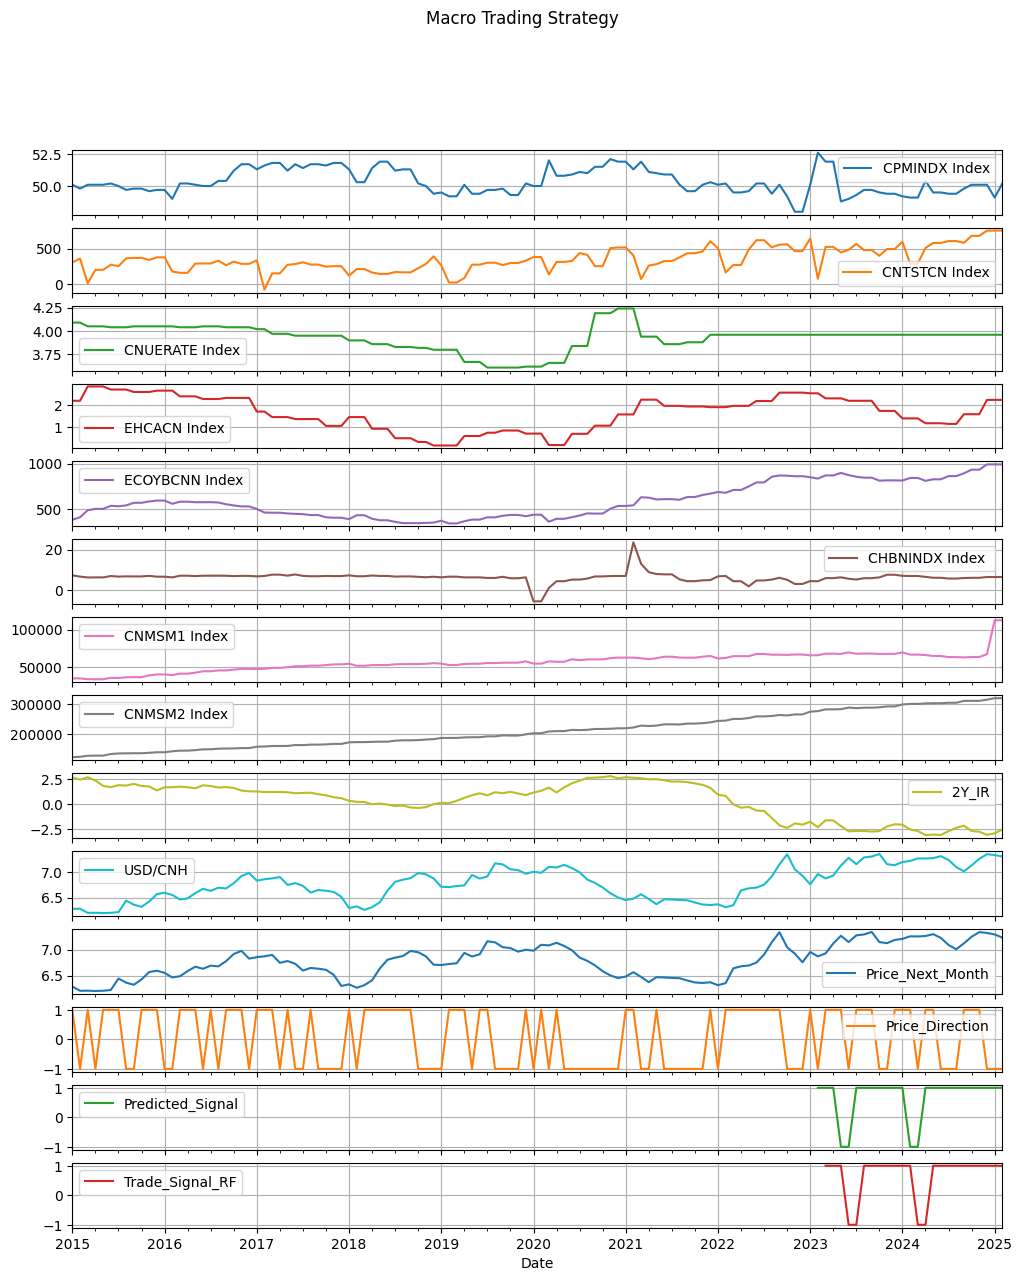

In [316]:
monthly_macro.plot(subplots=True, figsize=(12, 14), grid=True, title='Macro Trading Strategy')

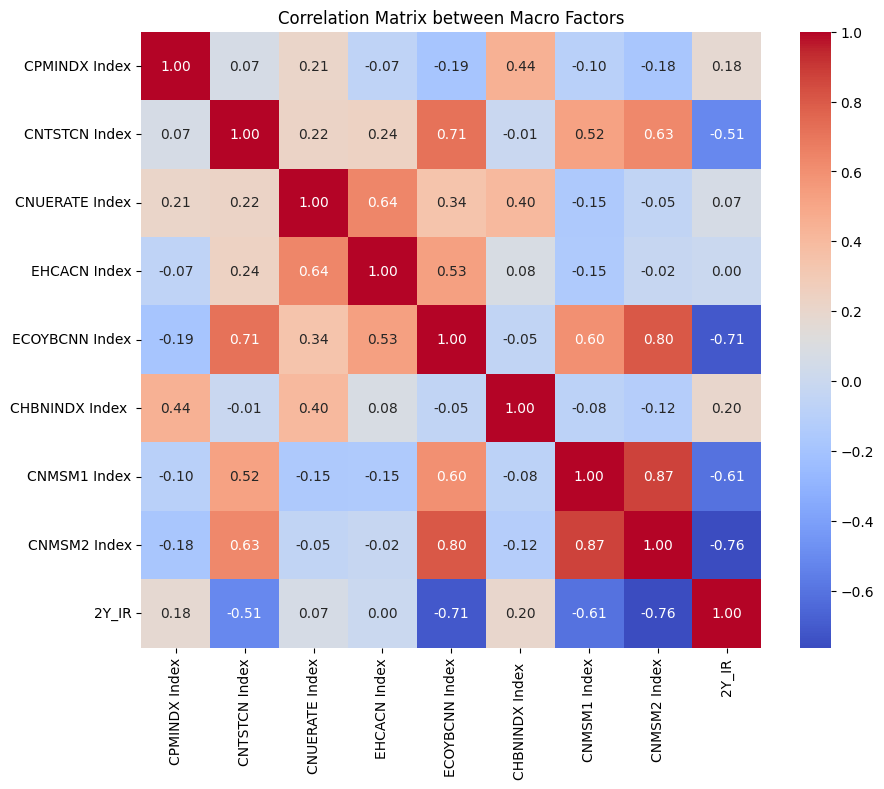

In [304]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = macro[indicators].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix between Macro Factors')
plt.show()


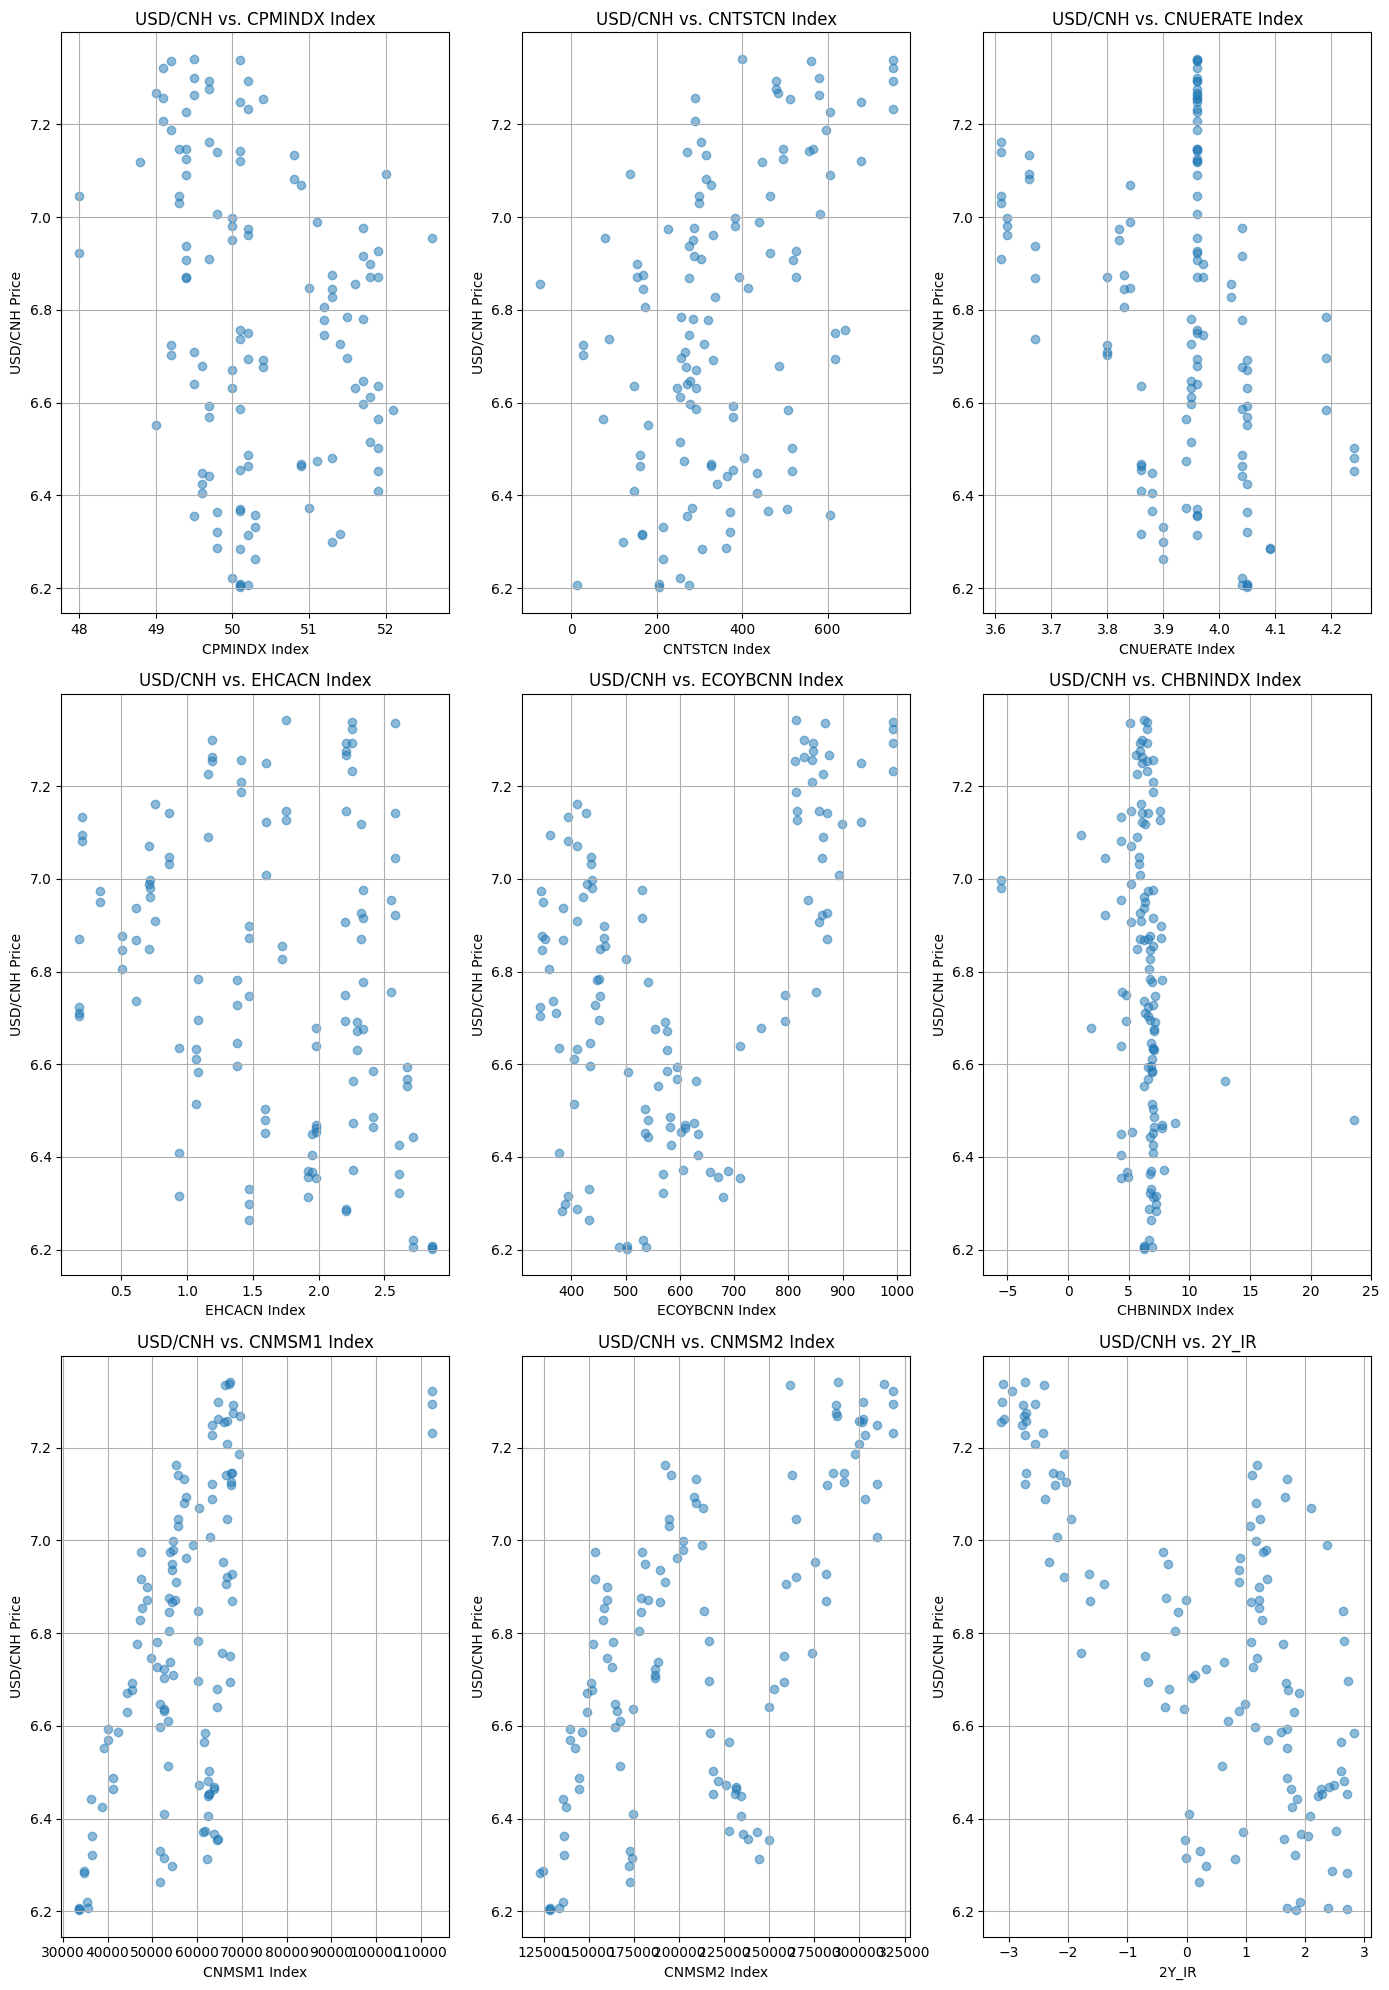

In [305]:
import matplotlib.pyplot as plt


plt.figure(figsize=(14, 20))

for i, indicator in enumerate(indicators, 1):
    plt.subplot(3, 3, i)
    plt.scatter(monthly_macro[indicator],monthly_macro['USD/CNH'], alpha=0.5)
    plt.xlabel(indicator)
    plt.ylabel('USD/CNH Price')
    plt.title(f'USD/CNH vs. {indicator}')
    plt.grid(True)

plt.tight_layout()
plt.show()


In [306]:
monthly_df = monthly_macro

In [307]:
monthly_macro.columns

Index(['CPMINDX Index', 'CNTSTCN Index', 'CNUERATE Index', 'EHCACN Index',
       'ECOYBCNN Index', 'CHBNINDX Index ', 'CNMSM1 Index', 'CNMSM2 Index',
       '2Y_IR', 'USD/CNH'],
      dtype='object')

In [372]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Assume your current ppp_df already contains macroeconomic indicators and USD_CNH price
# monthly_df = ppp_df.resample('M').last().dropna()

# Create target: price direction next month (1: up, -1: down)
monthly_df['Price_Next_Month'] = monthly_df['USD/CNH'].shift(-1)
monthly_df['Price_Direction'] = np.where(monthly_df['Price_Next_Month'] > monthly_df['USD/CNH'], 1, -1)

# Drop last row (NaN due to shift)
monthly_df.dropna(inplace=True)

# Define features and target
features = ['CPMINDX Index', 'CNTSTCN Index', 'CNUERATE Index', 'EHCACN Index',
       'ECOYBCNN Index', 'CHBNINDX Index ', 'CNMSM1 Index', 'CNMSM2 Index', '2Y_IR']
X = monthly_df[features]
y = monthly_df['Price_Direction']


In [373]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Define the train-test split (80% sequential training, 20% sequential testing)
split_point = int(len(X) * 0.8)

# Sequential splitting
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]



from sklearn.preprocessing import PolynomialFeatures

pipeline_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l2', C=0.1, random_state=42))
])

pipeline_poly.fit(X_train, y_train)
y_pred_poly = pipeline_poly.predict(X_test)

print(classification_report(y_test, y_pred))



ValueError: Found input variables with inconsistent numbers of samples: [3, 4]

In [366]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



In [367]:
# from sklearn.neural_network import MLPClassifier

# model = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)


In [368]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
# from sklearn.linear_model import LogisticRegression

model.fit(X_train, y_train)
y_pred = model.predict(X_test)



ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [-1  1]

In [369]:
x-# Initialize Random Forest Classifier
# model = RandomForestClassifier(n_estimators=100, random_state=42)

# # Fit the model
# model.fit(X_train, y_train)


SyntaxError: invalid syntax (<ipython-input-369-2d60dbce9b5e>, line 1)

In [340]:
# from xgboost import XGBClassifier

# model = XGBClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)


In [353]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluation metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           1       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4

[[0 2]
 [0 2]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [360]:
# Add predictions to DataFrame
monthly_df.loc[X_test.index, 'Predicted_Signal'] = y_pred

# Trade signals based on prediction
monthly_df['Trade_Signal_RF'] = monthly_df['Predicted_Signal'].shift(1)  # shift to avoid look-ahead bias

# Display trade signals
print(monthly_df[['USD/CNH', 'Predicted_Signal', 'Trade_Signal_RF']].dropna())


            USD/CNH  Predicted_Signal  Trade_Signal_RF
Date                                                  
2023-06-30   7.2677               1.0              1.0
2023-07-31   7.1461               1.0              1.0
2023-08-31   7.2755               1.0              1.0
2023-09-30   7.2928               1.0              1.0
2023-10-31   7.3416               1.0              1.0
2023-11-30   7.1459               1.0              1.0
2023-12-31   7.1258               1.0              1.0
2024-01-31   7.1872              -1.0              1.0
2024-02-29   7.2078               1.0             -1.0
2024-03-31   7.2572               1.0              1.0
2024-04-30   7.2548               1.0              1.0
2024-05-31   7.2630               1.0              1.0
2024-06-30   7.2993               1.0              1.0
2024-07-31   7.2270               1.0              1.0
2024-08-31   7.0900               1.0              1.0
2024-09-30   7.0074               1.0              1.0
2024-10-31

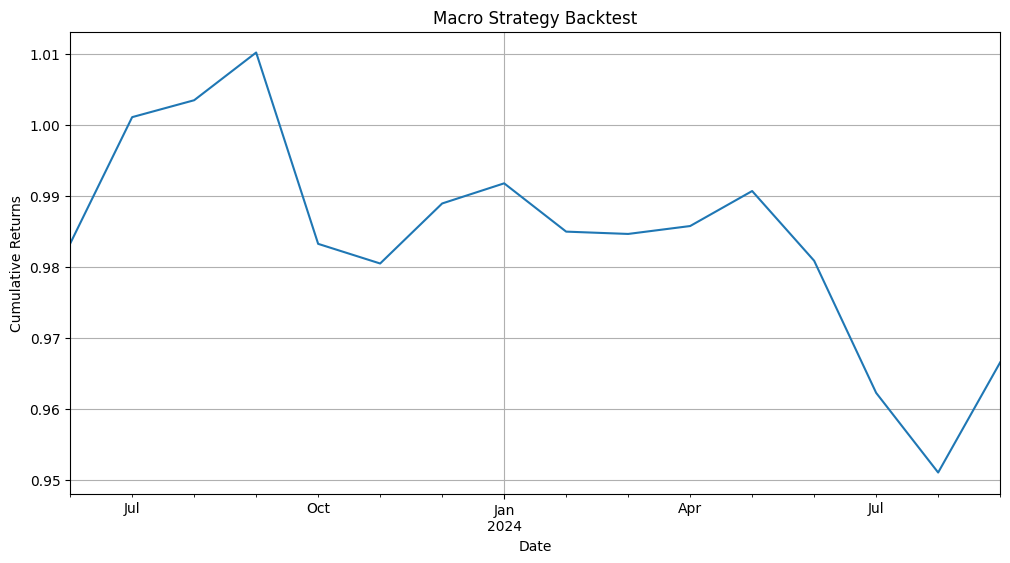

Sharpe Ratio: -0.57
            USD_CNH  Trade_Signal  Monthly_Returns  Cumulative_Returns
Date                                                                  
2023-07-31   7.1461           1.0         0.018108            1.001073
2023-08-31   7.2755           1.0         0.002378            1.003454
2023-09-30   7.2928           1.0         0.006692            1.010168
2023-10-31   7.3416           1.0        -0.026656            0.983241
2023-11-30   7.1459           1.0        -0.002813            0.980475
2023-12-31   7.1258           1.0         0.008617            0.988924
2024-01-31   7.1872           1.0         0.002866            0.991758
2024-02-29   7.2078          -1.0        -0.006854            0.984961
2024-03-31   7.2572           1.0        -0.000331            0.984635
2024-04-30   7.2548           1.0         0.001130            0.985748
2024-05-31   7.2630           1.0         0.004998            0.990675
2024-06-30   7.2993           1.0        -0.009905       

In [361]:

monthly_returns = monthly_df['USD/CNH'].pct_change().shift(-1) * monthly_df['Trade_Signal_RF']
cumulative_returns = (1 + monthly_returns.fillna(0)).cumprod()

# Performance Metrics
sharpe_ratio = (monthly_returns.mean() / monthly_returns.std()) * np.sqrt(12)  # Monthly returns annualized

# Compile results into a DataFrame
backtest_df = monthly_df.copy()
backtest_df = pd.DataFrame({
    'USD_CNH': monthly_df['USD/CNH'],
    'Trade_Signal': monthly_df['Trade_Signal_RF'],
    'Monthly_Returns': monthly_returns,
    'Cumulative_Returns': cumulative_returns
}).dropna()

# Plot Cumulative Returns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
backtest_df['Cumulative_Returns'].plot(title='Macro Strategy Backtest')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

# Output Performance Metrics
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(backtest_df.tail(15))

In [349]:
model

LogisticRegression(C=0.1, max_iter=500)

In [376]:
df

,CPMINDX Index,CNTBI2 Index,CNTSTCN Index,CHBGRMBI Index,CNUERATE Index,GCNY10YR Index,CNGDPYOY Index,EHCACN Index,HSI Index,H1DBTO Index,SPX Index,USGG10YR Index,USGG2YR Index,ECOYBCNN Index,CHBNINDX Index,CNMSM1 Index,CNMSM2 Index,2Y_IR
Date,,,,,,,,,,,,,,,,,,
2015-01-01,50.1,3.3082,306.40,100.0000,4.09,3.650,7.3,2.21,23605.04,368480.0,2058.90,2.1712,0.6645,383.1,7.28,34805.64,122837.48,2.6437
2015-01-02,50.1,3.3082,306.40,100.0000,4.09,3.650,7.3,2.21,23857.82,368480.0,2058.20,2.1105,0.6647,383.1,7.28,34805.64,122837.48,2.6435
2015-01-05,50.1,3.3071,306.40,100.8348,4.09,3.650,7.3,2.21,23721.32,2596900.0,2020.58,2.0320,0.6568,383.1,7.28,34805.64,122837.48,2.6503
2015-01-06,50.1,3.2901,306.40,100.9250,4.09,3.640,7.3,2.21,23485.41,1411140.0,2002.61,1.9402,0.6250,383.1,7.28,34805.64,122837.48,2.6651
2015-01-07,50.1,3.2522,306.40,101.2659,4.09,3.650,7.3,2.21,23681.26,1300960.0,2025.90,1.9677,0.6091,383.1,7.28,34805.64,122837.48,2.6431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-07,50.2,1.5070,752.91,99.0489,3.96,1.845,5.4,2.25,24231.30,49444429.0,5770.20,4.3011,3.9997,992.2,6.47,112445.75,318524.72,-2.4927
2025-03-10,50.2,1.5355,752.91,98.9487,3.96,1.872,5.4,2.25,23783.49,46227845.0,5614.56,4.2131,3.8833,992.2,6.47,112445.75,318524.72,-2.3478
2025-03-11,50.2,1.5975,752.91,98.8319,3.96,1.945,5.4,2.25,23782.14,36187054.0,5572.07,4.2799,3.9431,992.2,6.47,112445.75,318524.72,-2.3456


In [375]:
# Import libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# Step 1: Fetch Data
data = yf.download(['CNH=X', '^HSI', '^GSPC', '^IRX'],
                   start='2020-01-01', end='2024-03-12')['Adj Close'].dropna()
data.columns = ['USD_CNH', 'HSI', 'SPX', 'USD_Yield']

# Monthly Data (last prices)
monthly_data = data.resample('M').last()

# Features Engineering
monthly_data['PPP_Equilibrium'] = monthly_data['USD_CNH'].rolling(window=12).mean()
monthly_data['PPP_Deviation'] = (monthly_data['USD_CNH'] - monthly_data['PPP_Equilibrium']) / monthly_data['PPP_Equilibrium']

monthly_data['HSI_Return'] = monthly_data['HSI'].pct_change()
monthly_data['SPX_Return'] = monthly_data['SPX'].pct_change()
monthly_data['Equity_Spread'] = monthly_data['HSI_Return'] - monthly_data['SPX_Return']

monthly_data['CNH_Implied_Yield'] = monthly_data['USD_CNH'].pct_change().rolling(3).mean() * 12
monthly_data['Carry'] = monthly_data['USD_Yield']/100 - monthly_data['CNH_Implied_Yield']

monthly_data['PPP_Deviation'] = (monthly_data['USD_CNH'] - monthly_data['USD_CNH'].rolling(12).mean()) / monthly_data['USD_CNH'].rolling(12).mean()

# Drop NaNs
monthly_data = monthly_data.dropna()

# Target: Next month's price direction
monthly_data['Price_Next'] = monthly_data['USD_CNH'].shift(-1)
monthly_data['Target'] = np.where(monthly_data['Price_Next'] > monthly_data['USD_CNH'], 1, -1)
monthly_data.dropna(inplace=True)

# Features & target
features = ['PPP_Deviation', 'Equity_Spread', 'USD_Yield']
X = monthly_data[features]
y = monthly_data['Price_Next'] > monthly_data['USD_CNH']
y = y.astype(int)

# Sequential Train-Test Split (80%-20%)
split_point = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Train XGBoost Classifier
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Predict & Evaluate
y_pred = model.predict(X_test)
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

# Generate Trade Signals (shift by one month forward)
monthly_data['Predicted_Signal'] = np.nan
monthly_data.loc[X_test.index, 'Predicted_Signal'] = y_pred
monthly_data['Trade_Signal'] = monthly_data['Predicted_Signal'].shift(1).replace({1: 1, 0: -1})

# Backtesting the strategy
monthly_data['Strategy_Return'] = monthly_data['USD_CNH'].pct_change() * monthly_data['Trade_Signal'].shift(1)
monthly_data['Cumulative_Returns'] = (1 + monthly_data['Strategy_Return'].fillna(0)).cumprod() - 1

# Performance Metrics
sharpe_ratio = (monthly_data['Strategy_Return'].mean() / monthly_data['Strategy_Return'].std()) * np.sqrt(12)

print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

# Plot cumulative returns
import matplotlib.pyplot as plt

monthly_data['Cumulative_Returns'].plot(figsize=(12,6), title='Strategy Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

# Feature Importance
import matplotlib.pyplot as plt
importances = pd.Series(model.feature_importances_, index=features)
importances.plot(kind='bar', title='Feature Importance', figsize=(10,6))
plt.grid(True)
plt.ylabel('Importance')
plt.show()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CNH=X']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2024-03-12)')


ValueError: Length mismatch: Expected axis has 1 elements, new values have 4 elements